## 4. Linear ensemble filtering for the Lorenz-96 problem

In this notebook, we apply the stochastic ensemble Kalman filter to the Lorenz-96 problem.

To regularize the inference problem, we use a localization radius `L` to cut-off long-range correlations and improve the conditioning of the covariance matrix. We refers readers to Asch et al. [2] for further details.

[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

In [ ]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions

Load some packages to make nice figures

In [ ]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor.

In this example, we assume that the state is fully observable.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [ ]:
Nx = 40
Ny = 40

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [ ]:
Δtdyn = 0.05
Δtobs = 0.1

Define the time span of interest

In [ ]:
t0 = 0.0
tf = 100.0
Tf = ceil(Int64, (tf-t0)/Δtobs)

Define the properties of the initial condition

In [ ]:
m0 = zeros(Nx)
C0 = Matrix(1.0*I, Nx, Nx);

We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(t,x) = x$.

In [ ]:
h(t,x) = x
h(t,x,idx) = x[idx]

F = StateSpace(lorenz96!, h)

`ϵx` defines the additive process noise applied between the forecast step and the analysis step. The process noise is applied before to sample form the likelihood.

`ϵy` defines the additive observation noise. 

We assume that these noises have Gaussian distribution.

In [ ]:
σx = 1e-1
σy = 1.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

In [ ]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, m0, C0, 0, 0, 0, F);

Set initial condition of the true system

In [ ]:
x0 = model.m0 + sqrt(model.C0)*randn(Nx)

Run dynamics and generate data

In [ ]:
data = generate_lorenz96(model, x0, Tf);

Define a stochastic ensemble Kalman filter

In [ ]:
senkf = StochEnKF(x->x, model.ϵy, model.Δtdyn, model.Δtobs)

Define a ensemble transform Kalman filter

In [ ]:
etkf = ETKF(x->x, model.ϵy, model.Δtdyn, model.Δtobs, 20*model.Δtobs)

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [ ]:
Ne = 100 #ensemble size
X = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
X[model.Ny+1:model.Ny+model.Nx,:] .= sqrt(model.C0)*randn(model.Nx, Ne) .+ model.m0

Apply the sequential filter over the time window

The function `seqassim` provides a friendly API to experiment with the different ensemble filters, the tuning of the different inflation parameters...

In [36]:
Xsenkf = seqassim(F, data, Tf, model.ϵx, senkf, deepcopy(X), model.Ny, model.Nx, t0);

In [40]:
mean_hist(Xsenkf)

40×1001 Array{Float64,2}:
 -0.0772529   0.671643  1.48179  2.22409  …  10.889     10.1096      9.79508
  0.11264     0.766055  1.5988   2.17312      7.15719    4.09599    -0.724968
  0.0412414   1.10684   1.971    2.63784     -3.22202   -4.36576    -3.80734
  0.00578109  0.528408  1.44856  2.20054      5.92492    6.01441     3.96276
  0.0250425   1.24149   1.97013  2.73006      5.22572    7.28002     7.91408
  0.0321407   1.04096   1.91467  2.57123  …   0.526353  -1.81013    -3.55575
 -0.0309261   0.682864  1.498    2.01062      1.48125    1.7222      1.74452
  0.0211768   1.14937   2.0287   2.57297      7.30534    8.74021     9.78192
 -0.0283571   1.04909   1.89832  2.70086     13.2433     9.56535     1.88357
  0.0116546   1.30512   2.11245  2.83506      1.28943   -6.66731    -8.01848
  0.0447242   1.09445   1.91759  2.61285  …  -0.976774   2.65962     4.25066
  0.0331474   1.09662   2.06999  2.70299      0.80304    1.75893     7.60817
  0.050935    1.11063   2.14128  2.64851      3.8

`mean_hist` stacked together the ensemble mean over the assimilation window.

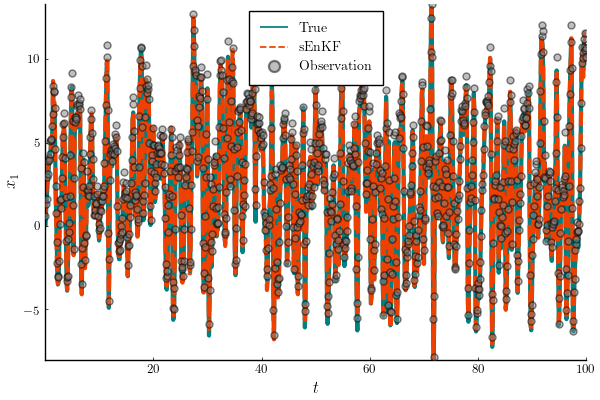

In [41]:
# Plot the first component of the state over time
nb = 1
ne = size(Xsenkf,1)-1
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1")
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")
plot!(plt, data.tt[nb:Δ:ne], mean_hist(Xsenkf)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, label = "sEnKF")
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5, label = "Observation")
plt

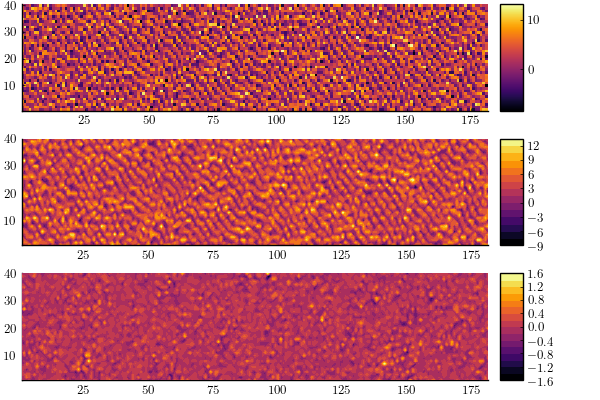

In [63]:
nb = 100
ne = size(Xsenkf,1)-1
Δ = 5

plt = plot(layout = grid(3,1))
contourf!(plt[1,1], data.xt[:,nb:Δ:ne], color = :inferno)
contourf!(plt[2,1], mean_hist(Xsenkf)[:,1+nb:Δ:1+ne], color = :inferno)
contourf!(plt[3,1], mean_hist(Xsenkf)[:,1+nb:Δ:1+ne] .- data.xt[:,nb:Δ:ne] - , color = :inferno)

In [25]:
# Plot the different component of the state over time
nb = 1
ne = size(Xsenkf,1)-1
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (900, 1000))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  2, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xsenkf)[i,1+nb:Δ:1+ne], linewidth = 2, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

LoadError: [91mUndefVarError: Xsenkf not defined[39m